In [1]:
from pathlib import Path
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image

In [2]:

# sample_p_old = Path("/Users/hariomnarang/Downloads/project-6-at-2026-01-14-06-29-107a76eb.json")
sample_p = Path("/Users/hariomnarang/Downloads/project-6-at-2026-01-17-07-16-eb8e5c49.json")
with open(sample_p) as f:
    sample = json.load(f)

In [3]:
list(sample[0].keys())

['id',
 'annotations',
 'drafts',
 'predictions',
 'data',
 'meta',
 'created_at',
 'updated_at',
 'inner_id',
 'total_annotations',
 'cancelled_annotations',
 'total_predictions',
 'comment_count',
 'unresolved_comment_count',
 'last_comment_updated_at',
 'project',
 'updated_by',
 'comment_authors']

In [75]:
def get_image_path(content):
    ext_p = content["data"]["image"].split("?d=")[1]
    ext_p = f"/{ext_p}"
    return Path(ext_p)

class InputStream:
    def __init__(self, data):
        self.data = data
        self.i = 0

    def read(self, size):
        out = self.data[self.i:self.i + size]
        self.i += size
        return int(out, 2)


def access_bit(data, num):
    """ from bytes array to bits by num position"""
    base = int(num // 8)
    shift = 7 - int(num % 8)
    return (data[base] & (1 << shift)) >> shift


def bytes2bit(data):
    """ get bit string from bytes data"""
    return ''.join([str(access_bit(data, i)) for i in range(len(data) * 8)])

def rle_to_mask(rle: list[int], height: int, width: int) -> np.array:
    """
    Converts rle to image mask
    Args:
        rle: your long rle
        height: original_height
        width: original_width

    Returns: np.array
    """

    rle_input = InputStream(bytes2bit(rle))

    num = rle_input.read(32)
    word_size = rle_input.read(5) + 1
    rle_sizes = [rle_input.read(4) + 1 for _ in range(4)]
    # print('RLE params:', num, 'values,', word_size, 'word_size,', rle_sizes, 'rle_sizes')

    i = 0
    out = np.zeros(num, dtype=np.uint8)
    while i < num:
        x = rle_input.read(1)
        j = i + 1 + rle_input.read(rle_sizes[rle_input.read(2)])
        if x:
            val = rle_input.read(word_size)
            out[i:j] = val
            i = j
        else:
            while i < j:
                val = rle_input.read(word_size)
                out[i] = val
                i += 1

    image = np.reshape(out, [height, width, 4])[:, :, 3]
    return image

def crop_from_mask(image, mask, pad=0):
    """
    image: H x W x C
    mask:  H x W (bool or 0/1)
    pad:   optional padding in pixels
    """
    mask = mask.astype(bool)

    ys, xs = np.where(mask)
    if len(xs) == 0:
        raise ValueError("Mask is empty")

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    # Optional padding
    y1 = max(0, y1 - pad)
    x1 = max(0, x1 - pad)
    y2 = min(image.shape[0] - 1, y2 + pad)
    x2 = min(image.shape[1] - 1, x2 + pad)

    crop = image[y1:y2+1, x1:x2+1]
    crop_mask = mask[y1:y2+1, x1:x2+1]

    # Zero background inside the crop (optional but usually desired)
    crop = crop * crop_mask[..., None]

    return crop, crop_mask




class ImageSaver:
    def __init__(self, dest):
        self.d = dest
        self.d.mkdir(exist_ok=True, parents=True)

    def save(self, img_arr, index):
        p = self.d / f"{index}.png"
        matplotlib.image.imsave(p, img_arr)
        return p

def extract_from_single_result(content):
    p = get_image_path(content)
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = []
    for annot in content["annotations"]:
        for res in annot["result"]:
            # content["annotations"][0]["result"][0]
            # res["original_width"]
            mask = rle_to_mask(res["value"]["rle"], res["original_height"], res["original_width"])
            # print("mask for img=", p)
            crop, _ = crop_from_mask(img, mask)
            result.append(crop)
    return result


def extract_and_show(content):
    crops = []
    for _, sample in enumerate(content):
        crops.extend(extract_from_single_result(sample))
    _, ax = plt.subplots(1, 4)
    for (c, a) in zip(crops[:4], ax):
        a.imshow(c)
    plt.tight_layout()
    plt.show()
    return crops

In [17]:
def rm_problematic_sample():
    # label studio bug, many annotations in one image are failing
    sample[93]["annotations"]

    problematic = sample.pop(93)
    return problematic

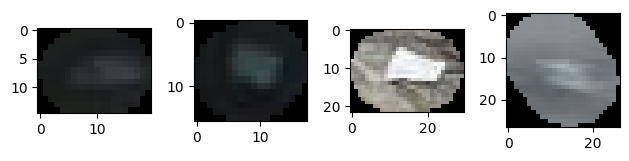

In [210]:
crops = extract_and_show(sample)

In [77]:
saver = ImageSaver(Path.cwd().parent / "crops" / "v2")

In [433]:
import cv2
from typing import Literal
import numpy as np

def _do_morphology(_m, iopen=1, idilate=1):
    # # Clean noise
    kernel = np.ones((3, 3), np.uint8)
    _m = cv2.morphologyEx(_m, cv2.MORPH_OPEN, kernel, iterations=1)
    _m = cv2.morphologyEx(_m, cv2.MORPH_DILATE, kernel, iterations=1)
    return _m

def _show(img, gray, extracted):
    _, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(img)
    ax2.imshow(extracted)
    ax3.hist(gray.flat, bins=100)
    plt.show()


def _crop_centre(img, radius):
    # blacks everything else out
    h, w = img.shape[0], img.shape[1]
    ch, cw = h // 2, w // 2
    mask = np.zeros(img.shape, dtype=np.uint8)
    mask[ch-radius:ch+radius, cw-radius:cw+radius] = img[ch-radius:ch+radius, cw-radius:cw+radius]
    return mask


def _crop_edge(img, length, width, corner: Literal["LT", "LB", "RT", "RB"]):
    my, mx = img.shape[0], img.shape[1]
    sy = 0 if corner in ["LT", "RT"] else my
    sx = 0 if corner in ["LT", "LB"] else mx
    length = -length if corner in ["LB", "RB"] else length
    sy2 = sy + length

    width = -width if corner in ["RT", "RB"] else width
    sx2 = sx + width

    return img[min(sy, sy2):max(sy, sy2), min(sx, sx2):max(sx, sx2)]

def _crop_edge(img, sy, sx, length, width):
    return img[sy:sy+length, sx:sx+width]

def remove_hsv_range(
    img_bgr,
    lower_hsv,
    upper_hsv,
    replacement_color=(0, 0, 0)
):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    result = img_bgr.copy()
    result[mask > 0] = replacement_color
    return result, mask

BROWN_LOWER = (10, 50, 50)
BROWN_UPPER = (30, 200, 200)

GRAY_LOWER = (0, 0, 40)
GRAY_UPPER = (180, 40, 220)

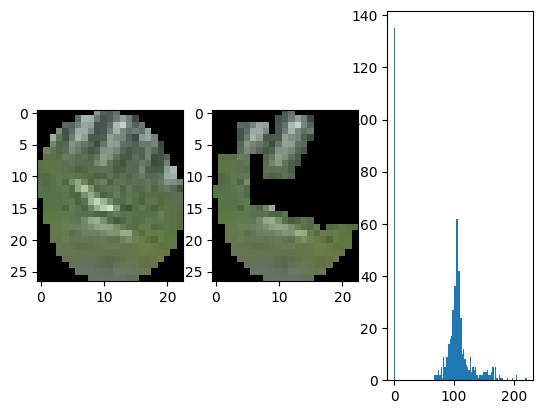

In [797]:
index = 114

img = crops[index].copy()
# img, _ = remove_hsv_range(img, GRAY_LOWER, GRAY_UPPER)
# print(img.shape)


img2 = img
# img2 = _crop_centre(img, 10)
# img2 = _crop_edge(img, 10, 10, 9, 20)

gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
# Threshold (adjust value if needed)
# _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)



mask = _do_morphology(mask)


extracted = cv2.bitwise_and(img2, img2, mask=mask)
_show(img, gray, extracted)

In [794]:
saver.save(extracted, index)

PosixPath('/Users/hariomnarang/Desktop/personal/roads/training/crops/v2/113.png')